# 17 - TensorFlow - Keras: Clasificación de tendencias politicas en tweets con LSTM (Long Short-Term Memory)

* En este notebook vamos a clasificar una serie de tweets etiquetados por un partido político (psoe, pp, vox, podemos y ciudadanos) que corresponden a la tendencia politica de la cuenta que publicó ese tweet,


* El ejercicio que vamos a realizar a continuación es muy similar al realizado en el notebook *13_PoC_Tendencias_Politicas_Twitter_Generacion_Exportacion_Modelos.ipynb* y *16_TensorFlow_Keras_MLP_Tendencias_Politicas_Twitter.ipynb* y se pueden comparar los resultados que vamos a obtener con este tipo de ***Redes Neuronales Recurrentes, las LSTM***


* Los pasos que vamos a dar son los siguientes:

    1. Cargar los datos
    2. Normalizar los tweets (igual que en el notebooks anteriormente descritos)
    3. Particionado de datos (Train y Test)
    4. One-Hot Encoding y codificación del target
    5. Creacción de las secuencias de palabras
    5. Definición de la Red Neuronal
    6. Entrenamiento de la Red Neuronal
    7. Evaluación del modelo
    
    
<hr>



## Carga de Datos


* El fichero que contiene los tweets lo podemos leer como un '*csv*' con pandas pasandole como separador '***::::***'.


* Este fichero esta estructurado de la siguiente manera
    - **Cuenta**: Cuenta de twitter
    - **Partido**: Partido político al que pertenece (ciudadanos, podemos, pp, psoe)
    - **Timestamp**: Instante en el que se publicó el tweet
    - **Tweet**: Tweet.
    
    
* Leemos los datos y filtramos los tweets; quedamos con los tweets a partir de una fecha dada.

In [1]:
import datetime
import numpy as np
import time
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format

# Leemos el fichero y lo pasamos a un DataFrame
TWEETS_FILE = './data/tweets_politica.csv'
df = pd.read_csv(TWEETS_FILE, sep='::::', engine='python')

# Eliminamos los tweets que tengan algún valor a nulo
df = df.dropna()
print('Número de Tweets Cargados: {num}'.format(num=df.shape[0]))

# Los ordenamos por fecha
df = df.sort_values(by='timestamp')

# Filtramos los tweets a partir de una fecha
DATE = "01/04/2021"
timestamp = time.mktime(datetime.datetime.strptime(DATE, "%d/%m/%Y").timetuple())
df = df[df.timestamp >= timestamp]

# Mostramos un sample y el número de tweets a procesar
print('Número de Tweets a procesar: {num}'.format(num=df.shape[0]))
df.sample(10)

Número de Tweets Cargados: 144861
Número de Tweets a procesar: 52158


,cuenta,partido,timestamp,tweet
109283,InesArrimadas,ciudadanos,"1,624,394,681.00",Magistral. No se lo pierdan 👏🏼👏🏼👏🏼 https://t.c...
137310,PabloEchenique,podemos,"1,635,417,562.00",El PP condenado por corrupción por segunda vez...
142528,_JuanEspadas,psoe,"1,637,174,760.00",Su Eminencia contará con un centro de diversid...
129479,SaraGimnez,ciudadanos,"1,632,987,804.00",Nuestra Constitución no puede seguir usando un...
104525,populares,pp,"1,622,526,231.00",“El Partido Popular asegurará que todos los es...
115948,populares,pp,"1,627,468,571.00","🇻🇪 ""Pedimos al Gobierno que conceda urgentemen..."
136980,IdoiaVR,podemos,"1,635,313,275.00",¡Comienza el II Foro Transnacional de Alternat...
106594,PSOE,psoe,"1,623,560,401.00",Es el momento de encontrar solución a problema...
99072,Santi_ABASCAL,vox,"1,619,883,664.00",#LosTrabajadoresDeEspañaConVOX#VoxConSOLIDARID...
126288,jmespejosaav,ciudadanos,"1,619,712,984.00",En Cs decimos alto y claro #InsultosNoToleranc...


* Tweets publicados por partido político

In [2]:
df_count = df.groupby('partido')['tweet'].count().reset_index().sort_values(by='tweet', ascending=False)
df_count['PCT'] = (df_count['tweet'] / df_count['tweet'].sum())*100
df_count

,partido,tweet,PCT
4,vox,13300,25.50
2,pp,10779,20.67
3,psoe,10637,20.39
1,podemos,9671,18.54
0,ciudadanos,7771,14.90


* Nos quedamos solo con el nombre del partido y el tweet

In [3]:
tweets = [list(x) for x in df[['tweet', 'partido']].values]
print('Número de Tweets Cargados: {num}'.format(num=len(tweets)))

Número de Tweets Cargados: 52158


<hr>


## Normalización


* Utilizamos ***spaCy*** para la tokenización y normalización.


* Tras realizar un análisis del contenido de los tweets pasamos a realizar las siguientes acciones para ***normalizar*** los tweets:
    1. Pasamos las frases a minúsculas.
    2. Sustituimos los puntos por espacios ya que hay muchas palabras unidas por un punto
    3. Quitamos la almuhadilla de los hashtags para considerarlos como palabras.
    4. Eliminamos los signos de puntuación.
    5. Eliminamos los enlaces(http) y las menciones (@)
    6. Pasamos la palabra a su lema


* Todos estos pasos los vamos a realizar en una misma función.

* Descartaremos aquellos tweets que tras ser normalizados no tengan por lo menos 3 palabras.


* ***NOTA***: Cuando trabajamos con Redes Neuronales Recurrentes y en especial con las LSTM aplicado al Procesamiento del Lenguaje Natural, no solo nos interesa saber las palabras que componen un tweet (o documento), si no tambien la secuencia de esas palabras dentro de la frase, por ese motivo ***vamos a tratar los tweets como secuencias de palabras y no como bolsas de palabras*** (como haciamos en los ejemplos anteriores). Por tanto no vamos a eliminar las palabras con menos de 3 caracteres ni las stop-words.


#### CUIDADO - IMPORTANTE:

* Dado que los procesos de normalización de textos son muy pesados y tardan mucho, se ha implementado despues de la normalización de los tweets, un proceso de guardado de los tweets ya normalizados. Por tanto:
    - Si es la primera vez que se ejecuta este notebook, se puede ejecutar completo sabiendo que se guardarán en un fichero binario los tweets normalizados. Este guardado se realiza [AQUI](#Escritura).
    - En caso de haberse ejecutado el proceso de normalización de tweets y haberse guardado este en un fichero binario, no será necesario ejecutar las dos siguientes celdas de código y bastaría con ejecutar la celda de código que lee el fichero binario con los tweets normalizados. Esto se hace en la siguiente [CELDA](#Lectura).

In [4]:
import spacy

from tqdm import tqdm

nlp = spacy.load('es_core_news_sm')

def normalize(tweets, min_words=5):
    """
    Función que dada una lista de tweets ([tweet, clase]), normaliza los tweets y devuelve una lista
    con los tweets normalizados, descartando aquellos tweets que tras la normalización tengan menos de
    "min_words" palabras en el tweet.
    
    :param tweets:       Lista de Tweets ([tweet, clase]) con el tweet y la clase a la que pertenece
    :param min_words:    Número minimo de palabras que tiene que tener un tweet tras la normalización
    :return:             Lista de Tweets ([tweet, clase]) normalizados
    """
    tweets_list = []
    for tweet in tqdm(tweets):
        # Tokenizamos el tweets realizando los puntos 1,2 y 3.
        tw = nlp(tweet[0].lower().replace('.', ' ').replace('#', ' ').strip())
        
        # Normalizamos Puntos 4,5y 6
        tw = ([word.lemma_ for word in tw if (not word.is_punct)
               and (not word.text.startswith('@'))
               and (not word.text.startswith('http'))
               and (not ':' in word.text)])
        
        # Eliminamos los tweets que tras la normalización tengan menos de "min_words" palabras
        if len(tw) >= min_words:
            tweets_list.append([' '.join(tw), tweet[1]])
    return tweets_list

# Normalizamos las frases
X_norm = normalize(tweets)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52158/52158 [05:43<00:00, 151.83it/s]


#### <a name="Escritura">Guardado de los tweets normalizados en un fichero binario</a>

* Se guarda una lista de listas, donde en cada una de las listas se tiene:
    - [0]: El Tweet normalizado
    - [1]: La clase a la que pertenece el Tweet

In [5]:
import pickle

filename = './models/normalized_tweets_LSTM.pickle'
save_list = open(filename,"wb")
pickle.dump(X_norm, save_list)
save_list.close()


#### <a name="Lectura">Lectura de los tweets normalizados de un fichero binario</a>

* Lectura de una lista con la siguiente estructura:
    - [0]: El Tweet normalizado
    - [1]: La clase a la que pertenece el Tweet

In [6]:
import pickle

filename = './models/normalized_tweets_LSTM.pickle'
X_norm = pickle.load(open(filename, 'rb'))


<hr>


## Particionado de Datos (Train y Test)

* Dado que las temáticas de los tweets varian en función del tiempo (tienen caracter temporal), vamos a particionar los datos temporalmente.


* Seleccionaremos como tweets de entrenamiento aquellos que se han escrito hasta una determinada fecha y como tweets de test los últimos tweets escritos.


* Seleccionaremos un 2% de tweets de test, siendo estos los últimos tweets registrados en el dataset (los tweets están escritos de manera cronológica).


* Por tanto nos vamos a quedar con:
    - 98% de datos de entrenamiento
    - 2% de datos de test

In [7]:
# Divido los datos en dos listas 
#     X: los tweets
#     y: target (polaridad)

X = [doc[0] for doc in X_norm]
y = np.array([doc[1] for doc in X_norm])

# Particionamos los datos en Entrenamiento y Test

PCT_TEST = 0.02
n_tail = len(X) - int(len(X) * PCT_TEST)
print('Corte en el tweet número {} de los {} tweets del Dataset.'.format(n_tail, len(X)))

X_train = X[:n_tail]
y_train = y[:n_tail]
X_test = X[n_tail:]
y_test = y[n_tail:]

print('Tweets de entrenamiento: {}'.format(len(X_train)))
print('Tweets de Test: {}'.format(len(X_test)))


Corte en el tweet número 48758 de los 49753 tweets del Dataset.
Tweets de entrenamiento: 48758
Tweets de Test: 995


<hr>


## One-Hot Encoding y codificación del target


* Con las Redes Neuronales Recurrentes vamos a tratar los tweets como secuencias de palabras y por tanto tenemos que realizar una codificación de todas palabras que aparecen en los tweets.


* Para ello TensorFlow nos proporciona una función llamada "one_hot" que dado un texto y el tamaño que tendrá nuestro vocabulario, nos codifica el texto por palabras. En el siguiente enlace esta la documentación de esta función:<br>
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/one_hot


* Veamos a continuación un ejemplo de como codificamos los textos:


```python
one_hot("Esto es un ejemplo de onehot encoding", 100)
```

```ssh
>> [6, 88, 30, 81, 31, 52, 22]
```

* Si realizamos una codificación de un string que continene palabras identicas, nos lo codifica con el mismo identificador como es de esperar:

```python
one_hot("Esto es otro ejemplo", 100)
```

```ssh
>> [6, 88, 79, 81]
```


* Por tanto vemos como utiliza identificadores numéricos del 1 al 100 para codificar las palabras de los strings:

    + "Esto" = 6
    + "es" = 88
    + "un" = 30
    + "ejemplo" = 81
    + "de" = 31
    + "onehot" = 52
    + "encoding" = 22
    + "otro" = 79
    
    
* Los identificadores que asigna a las palabras los obtiene aplicando una función "*hash*" a las palabras, de ahí que no sea necesario crear un "modelo" de "one-hot Encode" (como en scikit) para codificar otros strings (strings a predecir). 


* Lo único que hay que respetar para que nos codifique una misma palabra con el mismo identificador es el ***tamaño del vocabulario 'n'*** que se le pasa a la función "*one_hot(text, n)*" que en el ejemplo puesto anteriormente tiene valor *100*.


* Este valor '*n*' del vocabulario debe de tener (a priori) un valor lo suficientemente grande como para poder codificar todas las posibles palabras que podamos utilizar en una lengua (Español, Inglés, Alemán, etc.).


* El último paso que vamos a realizar es la codificación del nombre del partido político utilizando la clase "LabelEncoder()" de scikit.
    

In [8]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import one_hot

# Hacemos un one-hot encoder del texto
VOCAB_SIZE = 100000 # Poner un valor muy alto
X_train = [one_hot(doc, VOCAB_SIZE) for doc in X_train]
X_test = [one_hot(doc, VOCAB_SIZE) for doc in X_test]

# Codificación del Target
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

<hr>


## Creacción de las secuencias de palabras


* Las Redes Neuronales necesitan un tamaño fijo de entrada y los tweets tienen un número variable de palabras, por lo que hay que hay que transformar los tweets a secuencias de palabras de tamaño fijo.


* Para realizar esta labor, TensorFlow nos proporciona la función "*pad_sequences(sequences, maxlen)*" que dada una lista de secuencias nos devuelve esa secuencia con el tapaño que le hayamos indicado como parámetro, rellenando en caso de que la secuencia sea de mayor tamaño con algún valor por defecto (en principio a cero). En el siguiente enlace esta la documentación de esta función:<br>
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences


* Un ejemplo de esta función sería la siguiente, en el que indicamos que nos devuelva las secuencias que le pasamos como parámetro con un tamaño de '10' posiciones y rellenando las posiciones faltantes con ceros (value=0) añadiendolos al final de la secuencia (padding='post'):

```python
sequences = [[6, 88, 30, 81, 31, 52, 22], [6, 88, 79, 81]]
pad_sequences(sequences=sequences, maxlen=10, padding='post', value=0)
```


```ssh
array([[ 6, 88, 30, 81, 31, 52, 22,  0,  0,  0],
       [ 6, 88, 79, 81,  0,  0,  0,  0,  0,  0]], dtype=int32)
```


* A continuación pasamos a crear las secuencias de los tweets (50 elementos) tanto de entrenamiento como de test:


In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_WORDS_TWEET = 50
pad_corpus_train = pad_sequences(X_train, maxlen=MAX_WORDS_TWEET, padding='post')
pad_corpus_test = pad_sequences(X_test, maxlen=MAX_WORDS_TWEET, padding='post')

<hr>


# Definición de la Red Neuronal


* La arquitectura de la red para la clasificación de las tendencias políticas es la siguiente:
<span></span><br><br>
    - ***Capa Embedding***: Capa de Embedding que soportará un tamaño de 100.000 palabras (VOCAB_SIZE) y cada palabra estará representada por 32 características (EMBEDDING_SIZE). -*ver Bonus Track II*-
<span></span><br><br>
    - ***Capa LSTM***: Capa LSTM con 32 celdas de memoria. Son 32 por el tamaño de representación de la palabra (EMBEDDING_SIZE).
<span></span><br><br>
    - ***Capa 4***: Capa de salida con 5 neurona (una por tendencia política) y una función de activación 'softmax' para que nos "normalice la salida"
    
    
* Para la capa de salida aplicamos un dropout del 20% para que nuestra red no se sobreajuste y generalize mejor


* Por último vamos a compilar la red:
<span></span><br><br>
    - ***Función de perdida: 'categorical_crossentropy'*** (Funciones de Perdida: https://www.tensorflow.org/api_docs/python/tf/keras/losses). En realidad usaremos la '*sparse_categorical_crossentropy*' ya que la salida no la hemos codificado con un one-hot encoding \[\[1,0,0,0,0\], \[0,1,0,0,0\], ..., \[0,0,0,0,1\],\] si no con un label encode \[0,1,2,3,4\].
<span></span><br><br>
    - ***Optimizador: 'adam'*** (Optimizadores: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)
<span></span><br><br>
    - Metricas: en cada epoch pediremos que nos muestre el accuracy.

In [10]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential

EMBEDDING_SIZE = 32

model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBEDDING_SIZE))
model.add(LSTM(EMBEDDING_SIZE))
model.add(Dropout(0.1))
model.add(Dense(5, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Imprimimos la arquitectura de la red
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          3200000   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 3,208,485
Trainable params: 3,208,485
Non-trainable params: 0
_________________________________________________________________


* Parámetros a calcular en la red:
    - Capa de Embedding: -> 100000 palabras * 32 caracterísiticas = 3200000
    - Capa LSTM: 4*(32 * 32 + 32<sup>2</sup> + 32) = 8320
    - Conexiones "LSTM -> Capa salida" = (32 * 5) + 5 = 165
    
    
<hr>


# Entrenamiento de la Red Neuronal


* Vamos a entrenar la red con los siguientes parámetros:
<span></span><br><br>
    - *batch_size = 128* : Cada 128 tweets se calculan los nuevos pesos de la red
<span></span><br><br>
    - *epochs = 10*
<span></span><br><br>
    - *validation_split = datos de test* 
    

* Dado que puede ser un entrenamiento muy pesado y que puede tardar varios minútos, vamos a utilizar la herramienta del "Tensorboard" para monitorizar la evolución de la función de perdida y el Accuracy.


* Para más información sobre esta herramienta ver el siguiente enlace:<br>https://www.tensorflow.org/tensorboard


* Básicamente lo que hacer Tensorboard es leer una serie de logs y representar esos logs por medio de una interfaz web.


* Para representar la evolución de la función de perdida y el Accuracy, tenemos que escribir estos valores en un log que debemos guardarlos en una ruta conocida ('tensorboard_logs/FECHA_EJECUCION') y que generaremos  en el siguiente código.


* Para instanciar el Tensorboard lo hacemos de la siguiente manera por consola, pasandole como parámetro la ruta donde se encuentran los logs: 
```ssh
>> tensorboard --logdir ./tensorboard_logs/
```

* Una vez instanciado el Tensorboard nos indicará que abramos en el navegador el siguiente enlace:<br> http://localhost:6006/

In [11]:
# Se fuerza a usar la CPU y no la GPU en caso de tener GPU en el ordenador
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [12]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

# Configuramos TensorBoard
now = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs('tensorboard_logs/{}'.format(now))
tensorboard_path = os.path.join('tensorboard_logs', now)
tensorboard = TensorBoard(log_dir=tensorboard_path,
                          histogram_freq=2,
                          write_graph=True,
                          write_images=True)

# Creamos el checkpoint para exportar el modelo que mejor accuracy tiene con los datos de test
model_path ='./models/LSTM_Best_Model'
checkpoint = ModelCheckpoint(model_path,
                             monitor='val_accuracy',
                             save_best_only = True,
                             save_weights_only = False,
                             mode='max',
                             verbose=0)

history=model.fit(pad_corpus_train, 
                  y_train, 
                  batch_size=128, 
                  epochs=10, 
                  validation_data=(pad_corpus_test, y_test), 
                  verbose=2,
                  callbacks=[tensorboard, checkpoint])



Epoch 1/10
381/381 - 7s - loss: 1.2700 - accuracy: 0.4621 - val_loss: 1.0120 - val_accuracy: 0.6452
INFO:tensorflow:Assets written to: ./models\LSTM_Best_Model\assets


INFO:tensorflow:Assets written to: ./models\LSTM_Best_Model\assets


Epoch 2/10
381/381 - 4s - loss: 0.6596 - accuracy: 0.7762 - val_loss: 0.8634 - val_accuracy: 0.7025
INFO:tensorflow:Assets written to: ./models\LSTM_Best_Model\assets


INFO:tensorflow:Assets written to: ./models\LSTM_Best_Model\assets


Epoch 3/10
381/381 - 4s - loss: 0.4033 - accuracy: 0.8712 - val_loss: 0.9505 - val_accuracy: 0.6854
Epoch 4/10
381/381 - 4s - loss: 0.2637 - accuracy: 0.9188 - val_loss: 1.0234 - val_accuracy: 0.7085
INFO:tensorflow:Assets written to: ./models\LSTM_Best_Model\assets


INFO:tensorflow:Assets written to: ./models\LSTM_Best_Model\assets


Epoch 5/10
381/381 - 4s - loss: 0.1788 - accuracy: 0.9469 - val_loss: 1.1261 - val_accuracy: 0.7005
Epoch 6/10
381/381 - 4s - loss: 0.1314 - accuracy: 0.9612 - val_loss: 1.1288 - val_accuracy: 0.7065
Epoch 7/10
381/381 - 4s - loss: 0.0989 - accuracy: 0.9713 - val_loss: 1.2082 - val_accuracy: 0.7035
Epoch 8/10
381/381 - 4s - loss: 0.0740 - accuracy: 0.9794 - val_loss: 1.4066 - val_accuracy: 0.6915
Epoch 9/10
381/381 - 4s - loss: 0.0594 - accuracy: 0.9834 - val_loss: 1.2937 - val_accuracy: 0.6905
Epoch 10/10
381/381 - 4s - loss: 0.0553 - accuracy: 0.9847 - val_loss: 1.5987 - val_accuracy: 0.6915


* Pintamos como evoluciona la función de perdida y el Accuracy por epoch tanto en entrenamiento como en test.

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

# Pintamos las métricas por epoch
def plot_metric(history, name, remove_first=0):
    metric_train = np.array(history.history[name])[remove_first:]
    metric_test = np.array(history.history['val_{}'.format(name)])[remove_first:]
    acum_avg_metric_train = (np.cumsum(metric_train) / (np.arange(metric_train.shape[-1]) + 1))[remove_first:]
    acum_avg_metric_test = (np.cumsum(metric_test) / (np.arange(metric_test.shape[-1]) + 1))[remove_first:]
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.title('{} - Epochs'.format(name))
    plt.plot(metric_train, label='{} Train'.format(name))
    plt.plot(metric_test, label='{} Test'.format(name))
    plt.grid()
    plt.legend(loc='upper center')
    plt.subplot(1, 2, 2)
    plt.title('AVG ACCUMULATIVE {} - Epochs'.format(name))
    plt.plot(acum_avg_metric_train, label='{} Train'.format(name))
    plt.plot(acum_avg_metric_test, label='{} Test'.format(name))
    plt.grid()
    plt.legend(loc='upper center')
    plt.show()

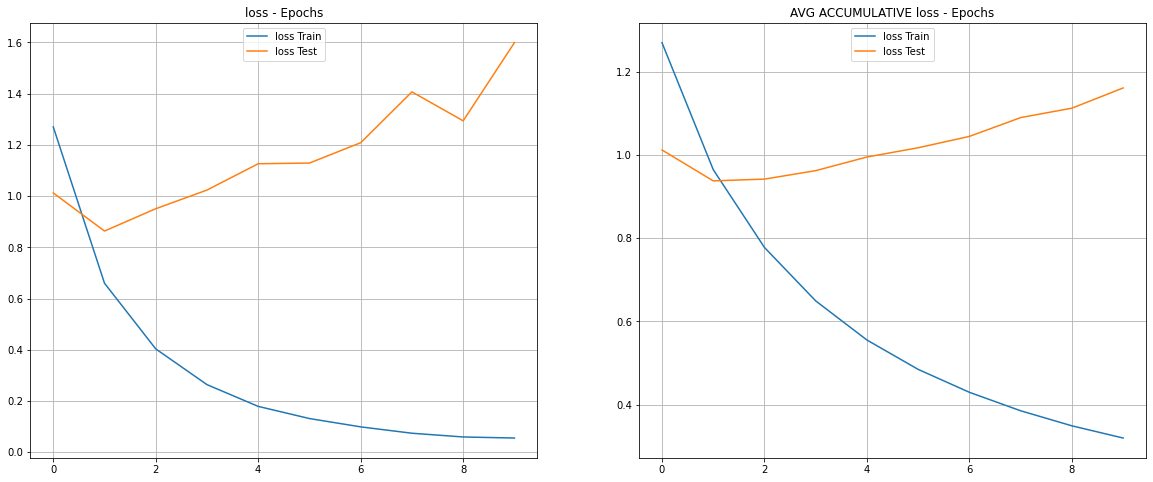

In [14]:
# Función de perdida
plot_metric(history=history, name='loss')

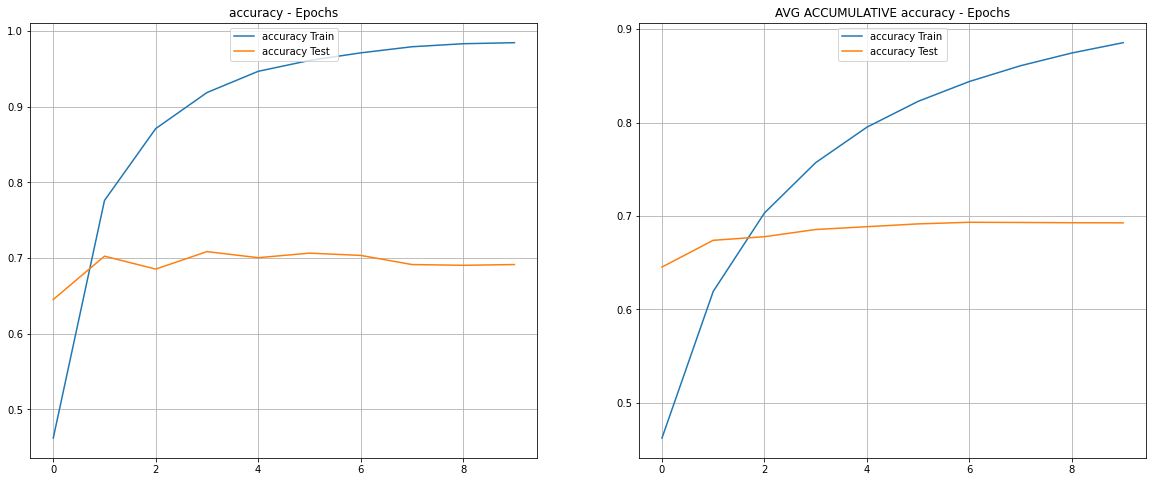

In [15]:
# Accuracy
plot_metric(history=history, name='accuracy')

<hr>


## Evaluamos el (mejor) modelo

* Pasamos a evaluar el modelo con los datos de test, calculando las siguientes métricas de evaluación:

    1. **Accuracy**
    2. **Precision**
    3. **Recall**
    4. **F1**

* Importamos el mejor modelo creado

In [16]:
from tensorflow.keras.models import load_model

model = load_model(model_path)

* Obtenemos las métricas

In [17]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

y_true = encoder.inverse_transform(y_test.reshape(-1))
y_pred = np.argmax(model.predict(pad_corpus_test), axis=-1)
y_pred = encoder.inverse_transform(y_pred.reshape(-1))

print('Accuracy: {acc:0.4f}'.format(acc=accuracy_score(y_true=y_true, y_pred=y_pred)))
print('F1: {f1:0.4f}'.format(f1=f1_score(y_true=y_true, y_pred=y_pred, average='weighted')))
print('Precision: {pre:0.4f}'.format(pre=precision_score(y_true=y_true, y_pred=y_pred, average='weighted')))
print('Recall: {rec:0.4f}'.format(rec=recall_score(y_true=y_true, y_pred=y_pred, average='weighted')))
print(classification_report(y_true=y_true, y_pred=y_pred))
labels = ['psoe', 'pp', 'vox', 'podemos', 'ciudadanos']
confusion_matrix_test = confusion_matrix(y_true=y_true,
                                         y_pred=y_pred,
                                         labels=labels)
confusion_matrix_train = confusion_matrix(y_true=encoder.inverse_transform(y_train.reshape(-1)), 
                                          y_pred=encoder.inverse_transform(np.argmax(model.predict(pad_corpus_train), axis=-1)), 
                                          labels=labels)


Accuracy: 0.7085
F1: 0.7097
Precision: 0.7198
Recall: 0.7085
              precision    recall  f1-score   support

  ciudadanos       0.67      0.60      0.64       144
     podemos       0.66      0.83      0.74       223
          pp       0.55      0.60      0.57       128
        psoe       0.85      0.70      0.77       288
         vox       0.75      0.72      0.73       212

    accuracy                           0.71       995
   macro avg       0.69      0.69      0.69       995
weighted avg       0.72      0.71      0.71       995



* Pintamos la matriz de confusión

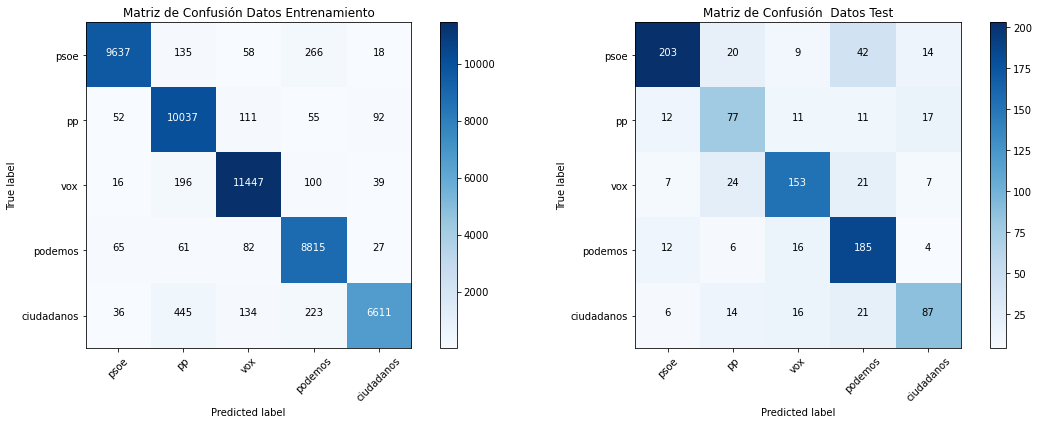

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Pintamos las matrices de confusión
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_confusion_matrix(confusion_matrix_train, classes=labels, title='Matriz de Confusión Datos Entrenamiento')
plt.subplot(1, 2, 2)
plot_confusion_matrix(confusion_matrix_test, classes=labels, title='Matriz de Confusión  Datos Test')
plt.show()

<hr>


# Bonus Track I - LSTM - 


* Las ***Redes Neuronales Recurrentes*** (RNN) constituyen una herramienta muy apropiada para ***modelar series temporales y para el Procesamiento del Lenguaje Natural***.


* Las RNN son, en principio, un modelo computacional más potente que las clásicas redes neuronales (Perceptrón). 


* Esta mayor potencia proviene del hecho de que las RNN son capaces de procesar secuencias temporales gracias a la posibilidad de ***recordar parcialmente la historia relevante*** de la secuencia por medio de una representación en forma de estado (***implementa una cierta memoria***).


* Esta memoria no existe de manera natural en las redes no recurrentes, utilizadas principalmente para el procesamiento de datos estáticos.


* Las LSTM (Long Short-Term Memory) son un tipo especial de unidades de memoria que conforman una red neuronal y que tienen la capacidad de recordar aquella información relevante que va aprendiendo durante el proceso de entrenamiento y olvidar aquella información que no considera relevante.


* La arquitectura de una unidad LSTM es la siguiente:


<img src="./imgs/028_lstm.png" style="width: 400px;"/>


* Las LSTM está formadas por los siguientes elementos:
<span></span><br><br>
    + ***$f_t$ -> forget gate*** (Puerta de Olvido): Que parte de la información del pasado no es importante.
<span></span><br><br>
    + ***$i_t$ -> input gate*** (Puerta de Entrada): De la información actual, hay algo que sea importante para recordar.
<span></span><br><br>
    + ***$\widetilde{C}_t$ -> candidate gate*** (Puerta Candidata): Si hay algo importante que recordar, cómo lo combinamos con la información del pasado.
<span></span><br><br>
    + ***$o_t$ -> output gate*** (Puerta de Salida): Que información es importante a corto plazo.
<span></span><br><br>    
    + ***$C_t$ -> state cell*** (Estado de la Celda): Guarda el estado de la celda actual.
    
    
<img src="./imgs/029_lstm.png" style="width: 600px;"/>
    
    
* Siendo:
    
$$f_t = sigmoid(W_f \cdot [h_{t-1}, X_t])$$

$$i_t = sigmoid(W_i \cdot [h_{t-1}, X_t])$$

$$\widetilde{C}_t = tanh(W_c \cdot [h_{t-1}, X_t])$$

$$o_t = sigmoid(W_o \cdot [h_{t-1}, X_t])$$

$$C_t = f_t * C_{t-1} + i_t * \widetilde{C}_t$$

$$h_t = o_t * tanh(C_t)$$


* Una capa con celdas LSTM estaría formada por cerlda LSTM conectadas en serie unas con otras de la siguiente manera:


<img src="./imgs/030_lstm.png" style="width: 700px;"/>



<hr>

# Bonus Track II - Embedding Layers - 


* Las "Embedding Layes" (capas de incrustación) son un tipo de técnicas que nos permiten representar las palabras y los documentos como un vector de características latentes.


* Para el caso particular de las palabras de un corpus, los vectores de características latentes que representan las palabras, son calculadas basándose en la ***hipótesis distribucional de Zellig Harris*** que dice: "*elementos lingüísticos con distribuciones similares tienen significados similares*"; es decir que ***las palabras que tienen un contexto similar, tendrán significados similares***.


* Por tanto con las técnicas que nos permiten representar a las palabras con vectores, tendremos que la similaridad entre pares de vectores que representen a pares de palabras con significado similar, tendran una similaridad alta y no así entre pares de palabras con significados distintos que tendrán una similaridad baja.


* Si por ejemplo esta similaridad la definimos como la distacia euclidea, tendremos que dos vectores que representan palabras con significados similares les separará una distancia pequeña frente a pares de palabras con significados dispares que les separará una distancia muy grande.


* Dos técnicas que se suelen utilizar para realizar este tipo de cálculo de características latentes de las palabras son:

    + Word2Vec
    + GloVe
    
    
* Este tipo de representación de las palabras viene muy bien para las RNN y en particular para las LSTM ya que cada palabra representada como un vector denso (y con sentido contextual frente a palabras similares entre sí) puede ser tomada como una entrada en una secuencia (que lo es) dentro de un documento.


* Veamos a continuación un sencillo ejemplo a partir del siguiente corpus

In [19]:
corpus = ['Hola me llamo Ricardo',
          'Hola me dicen Ricardo',
          'Saludos desde este Notebook llamado LSTM']

* Codificamos las palabras

In [20]:
from tensorflow.keras.preprocessing.text import one_hot

VOCAB_SIZE = 100
corpus_ohe = [one_hot(doc, VOCAB_SIZE) for doc in corpus]
for i in corpus_ohe:
    print(i)

[95, 74, 91, 66]
[95, 74, 54, 66]
[1, 13, 31, 92, 53, 50]


* Las pasamos a secuncias de tamaó fijo

In [21]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_WORDS_DOC = 6
pad_corpus = pad_sequences(corpus_ohe, maxlen=MAX_WORDS_DOC, padding='post')
pad_corpus

array([[95, 74, 91, 66,  0,  0],
       [95, 74, 54, 66,  0,  0],
       [ 1, 13, 31, 92, 53, 50]])

### Resultados del Embedding

* Para realizar esta representación, TensorFlow nos proporciona la clase "Embedding()" que tiene como importantes los siguientes parámetros:

    + ***input_dim***: Número de codificaciones distintas que pueden tener las palabras de nuestro corpus.
    + ***output_dim***: Número de características que queremos que tenga el vector que represente a las palabras.
    + ***input_length***: Máximo número de palabras en un documento.
    
    
* Para más información ver la documentación en el siguiente enlace:<br>https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

In [22]:
from tensorflow.keras.layers import Input, Embedding, Flatten
from tensorflow.keras.models import Model

WORD_VECTOR_DIMENSION = 2

words_input=Input(shape=(MAX_WORDS_DOC,),dtype='float64')  

# Creamos el Embedding
word_embedding=Embedding(input_dim=VOCAB_SIZE, 
                         output_dim=WORD_VECTOR_DIMENSION, 
                         input_length=MAX_WORDS_DOC)(words_input)

word_vec=Flatten()(word_embedding)

model = Model(inputs=[words_input],
              outputs=word_vec) 

# Imprimimos el modelo
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 6, 2)              200       
_________________________________________________________________
flatten (Flatten)            (None, 12)                0         
Total params: 200
Trainable params: 200
Non-trainable params: 0
_________________________________________________________________


* Compilamos el modelo ya que estamos ejecutando una Red Neuronal

In [23]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc']) 

* Obtenemos los vectores de características haciendo un "*predict()*" sobre el corpus con el modelo generado.

In [24]:
doc_embeddings=model.predict(pad_corpus)

* Vamos a obtener los vectores de las palabras de los documentos del corpus, cuyos documentos tienen un tamaño fijo de 6 palabras:

In [25]:
word_embeddings=doc_embeddings.reshape(-1, MAX_WORDS_DOC, WORD_VECTOR_DIMENSION)
for i, doc in enumerate(word_embeddings):
    print("\nCodificación de las 6 palabras del documento {}".format(i+1))
    print(doc)


Codificación de las 6 palabras del documento 1
[[ 0.04165563  0.03710497]
 [-0.01514999 -0.04378213]
 [-0.01458014 -0.03451867]
 [ 0.02183184  0.0273887 ]
 [-0.01430399  0.02967108]
 [-0.01430399  0.02967108]]

Codificación de las 6 palabras del documento 2
[[ 0.04165563  0.03710497]
 [-0.01514999 -0.04378213]
 [-0.0207073  -0.03494219]
 [ 0.02183184  0.0273887 ]
 [-0.01430399  0.02967108]
 [-0.01430399  0.02967108]]

Codificación de las 6 palabras del documento 3
[[-0.01528232 -0.01968292]
 [-0.04038664  0.00769208]
 [-0.02021893 -0.00491244]
 [-0.02929995  0.00058246]
 [-0.02069674  0.0290393 ]
 [-0.04645608 -0.01274401]]


* A continuación obtenemos la codificación de los documentos que no es más que la concatenación de los valores de las características de las palabras que forman el documento:

In [26]:
for i, doc in enumerate(doc_embeddings):
    print("\nCodificación del documento {}".format(i+1))
    print(doc)


Codificación del documento 1
[ 0.04165563  0.03710497 -0.01514999 -0.04378213 -0.01458014 -0.03451867
  0.02183184  0.0273887  -0.01430399  0.02967108 -0.01430399  0.02967108]

Codificación del documento 2
[ 0.04165563  0.03710497 -0.01514999 -0.04378213 -0.0207073  -0.03494219
  0.02183184  0.0273887  -0.01430399  0.02967108 -0.01430399  0.02967108]

Codificación del documento 3
[-0.01528232 -0.01968292 -0.04038664  0.00769208 -0.02021893 -0.00491244
 -0.02929995  0.00058246 -0.02069674  0.0290393  -0.04645608 -0.01274401]
